In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE 
from likelihood_funcs import * 
import corner
import scipy

from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [2]:
id = "0001"

sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")
sim_options = [("Lev4", "R2"), ("Lev4", "R3"), ("Lev5", "R3")]

sims = []

for lev, R in sim_options:
    try:
        sim = CCE.SXS_CCE(id, lev=lev, radius=R)
        sims.append(sim)
    except:
        pass

In [3]:
#sim = qnmfits.SXS(305, zero_time=(2,2))
#sims = [qnmfits.SXS(305, zero_time=(2,2), lev_minus_highest=-1)]

In [27]:
l_max = 2
n_max = 7

t0 = 0
T = 100

analysis_mask = (sim_main.times >= t0 - 1e-9) & (sim_main.times < t0+T - 1e-9)
analysis_times = sim_main.times[analysis_mask]

qnm_list = [(ell,2,n,1) for ell in np.arange(2, l_max+1) for n in np.arange(0, n_max+1)]
spherical_modes = [(ell, 2) for ell in np.arange(2, l_max+1)]

#qnm_list = [(ell,m,n,p) for ell in np.arange(2, l_max+1) for m in np.arange(-ell, ell+1) for n in np.arange(0, n_max+1) for p in [-1,1]]
#spherical_modes = [(ell, m) for ell in np.arange(2, l_max+1) for m in np.arange(-ell, ell+1)]

#qnm_list = [(ell,2,n,1) for ell in [2,3] for n in [0,1]]
#spherical_modes = [(2,2), (3,2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

# remove m = 0 modes 
#qnm_list = [qnm for qnm in qnm_list if qnm[1] != 0]
#spherical_modes = [mode for mode in spherical_modes if mode[1] != 0]

print(len(qnm_list))

8


In [29]:
param_list = [qnm for qnm in qnm_list for _ in range(2)] 

ls_fit = qnmfits.multimode_ringdown_fit(
    sim_main.times,
    sim_main.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=T,
    spherical_modes=spherical_modes,
)

ls_c = ls_fit['C']

true_as = []
for re_c, im_c in zip(np.real(ls_fit['C']), np.imag(ls_fit['C'])):
    true_as.append(re_c)
    true_as.append(im_c)

true_params = true_as

In [30]:
def data_mismatch(sim1, sim2, t0=0, modes=None, T=100, dt=0.01, shift=0):

    """
    
    This is only used to perform a general timeshift between the two simulations

    """

    new_times = np.arange(t0, t0 + T, dt)

    if modes is None:
        modes = list(sim1.h.keys())

    numerator = 0.0
    denominator1 = 0.0
    denominator2 = 0.0

    for mode in modes:

        h1 = sim1.h[mode]
        h2 = sim2.h[mode]

        #TODO do we still need these interpolators?

        interp_h1 = np.interp(new_times, sim1.times, h1)
        interp_h2 = np.interp(new_times - shift, sim2.times, h2)

        numerator += np.abs(np.trapz(interp_h1 * np.conjugate(interp_h2), x=new_times))
        denominator1 += np.abs(
            np.trapz(interp_h1 * np.conjugate(interp_h1), x=new_times)
        )
        denominator2 += np.abs(
            np.trapz(interp_h2 * np.conjugate(interp_h2), x=new_times)
        )

    denominator = np.sqrt(denominator1 * denominator2)

    return 1 - (numerator / denominator)

In [31]:
# Perform a time shift 

for i, sim in enumerate(sims):
    shifts = np.arange(-0.1, 0.1, 0.0001)
    # TODO: Review whether angle averaged mismatch is the best way to find the shift; it takes too long at the moment 
    shift_idx = np.argmin([data_mismatch(sim_main, sim, modes=None, shift=s) for s in shifts])
    sims[i].zero_time = -shifts[shift_idx]
    sims[i].time_shift()

In [32]:
# Interpolate the waveforms to the same times as the 'main' simulation 

sims_interp = []

for i, sim in enumerate(sims):
    sim_interp = {}
    for ell, m in sim.h.keys():
        sim_interp[ell,m] = spline(sim.times, np.real(sim.h[ell,m]), ext=1)(sim_main.times) + \
        1j*spline(sim.times, np.imag(sim.h[ell,m]), ext=1)(sim_main.times)
    sims_interp.append(sim_interp)

In [33]:
# Compute the difference in levels 

R = {}

# TODO: Search all levels/radii or just choose one? And is sum the best measure for the 'worst'? 

for i, sim in enumerate(sims_interp):
    for ell, m in spherical_modes:
        diff = sim_main.h[ell,m] - sim[ell,m]
        if (ell, m) not in R.keys() or np.abs(np.sum(diff)) > np.abs(np.sum(R[ell,m])):
            R[ell,m] = diff 

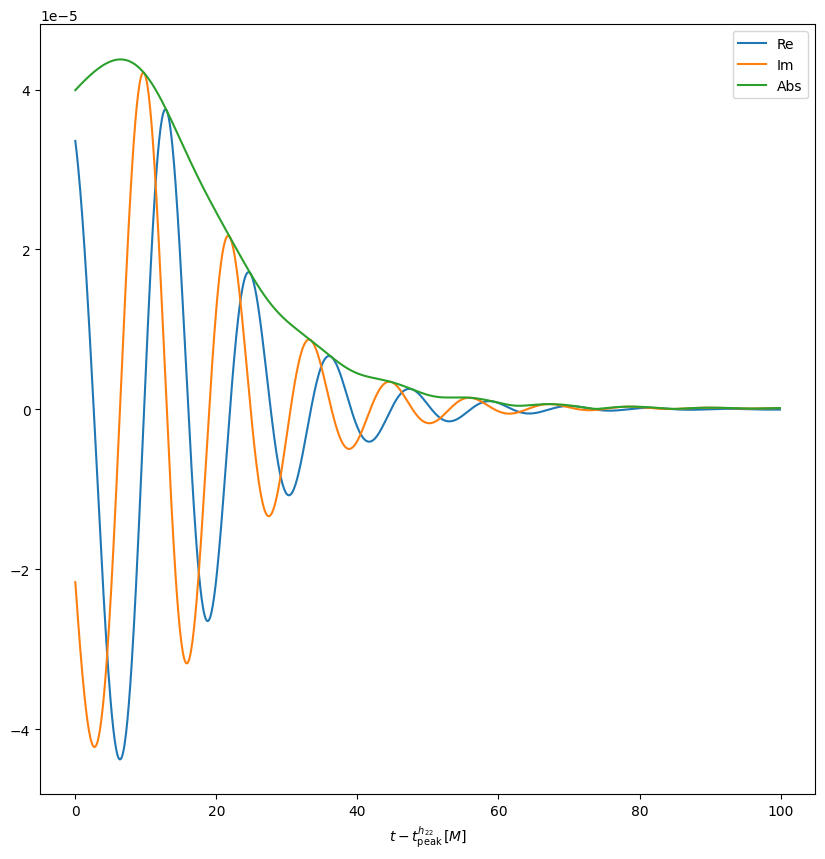

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(sim_main.times[analysis_mask], np.real(R[2,2])[analysis_mask], label='Re')
ax.plot(sim_main.times[analysis_mask], np.imag(R[2,2])[analysis_mask], label='Im')
ax.plot(sim_main.times[analysis_mask], np.abs(R[2,2])[analysis_mask], label='Abs')

#axs[i].set_ylabel(f'$h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev}}} - h_{{{ell}{m}}}^\mathrm{{Lev{sim.highest_lev-1}}}$')
#axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

ax.set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

ax.legend();

In [35]:
# Determine the amplitude of the residual 

residual_amplitudes = {}

for ell, m in R.keys():
    residual_amplitudes[(ell, m)] = np.max(np.abs(R[ell, m][analysis_mask]))

# Get the frequencies of the fundamental QNMs

qnm_decay_time = {}
qnm_lambda = {}

for ell, m in R.keys():
    omega = qnmfits.qnm.omega(ell, m, 0, 1, sim_main.chif_mag, sim_main.Mf)
    qnm_decay_time[(ell, m)], qnm_lambda[(ell, m)] = -1/omega.imag, (2*np.pi)/omega.real


In [36]:
# FOR TESTING  

def scaling(x, x_ref, n_scale, sigma_scale=0):
    return sigma_scale + (1-sigma_scale)/(1+(x_ref/x)**n_scale)

scaling_matrix = np.zeros((len(analysis_times), len(analysis_times)))
for i, xi in enumerate(analysis_times):
    for j, xj in enumerate(analysis_times):
        scaling_matrix[i,j] = \
            scaling(xi, x_ref=40, n_scale=-5, sigma_scale=0.1)*scaling(xj, x_ref=40, n_scale=-5, sigma_scale=0.1)
        
def rbf_kernel(x1, x2, sigma, length_scale):
    """Squared exponential kernel."""
    dist = np.abs(x1 - x2)
    return sigma**2 * np.exp(-dist**2 / (2*length_scale**2))

def periodic_kernel(x1, x2, length_scale, period):
    """Periodic kernel."""
    dist = np.abs(x1 - x2)
    return  np.exp(-2*np.sin(np.pi*dist/period)**2 / length_scale**2)

def combined_kernel(x1, x2, sigma, l, p):
    return rbf_kernel(x1, x2, sigma, l) * periodic_kernel(x1, x2, l, p)

/tmp/ipykernel_428460/3583583449.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return sigma_scale + (1-sigma_scale)/(1+(x_ref/x)**n_scale)


In [132]:
def squared_exp_element(t1, t2, sigma, lam):
    return sigma**2 * np.exp(-0.5 * (t1 - t2)**2 / lam**2) 

def smooth_ceil(t, t_max):
    return t / np.sqrt(1 + (t/t_max)**2)

def exponential_func(t, tau, const=17):
    return np.exp(-(t-const)/tau)

def new_func(t, tau, t_max=1, limit=0.02):
    return smooth_ceil(exponential_func(t, tau), t_max) + limit

def kernel(t1, t2, tau, sigma, lam):
    return squared_exp_element(t1, t2, sigma, lam) * new_func(t1, tau) * new_func(t2, tau)


In [133]:
# Construct kernel matrix

kernel_dict = {} 
n_times = len(analysis_times)

"""
new_scaling_matrix = np.zeros((n_times, n_times))
for i in range(n_times):
    for j in range(i, n_times):
        new_scaling_matrix[i,j] = \
            new_func(analysis_times[i], qnm_decay_time[(ell, m)], t_max=1, limit=0.05) * new_func(analysis_times[j], qnm_decay_time[(ell, m)], t_max=1, limit=0.05)
""" 

for (ell, m) in spherical_modes:
    kernel_matrix = np.zeros((n_times, n_times))
    for i in range(n_times):
        for j in range(i, n_times):
            kernel_matrix[i, j] = kernel(analysis_times[i], analysis_times[j], qnm_decay_time[(ell, m)], residual_amplitudes[(ell, m)], qnm_lambda[(ell, m)])
            #kernel_matrix[i, j] = combined_kernel(analysis_times[i], analysis_times[j], residual_amplitudes[(2, 2)], qnm_decay_time[(2, 2)], qnm_frequency[(2, 2)])
            if i != j:
                kernel_matrix[j, i] = kernel_matrix[i, j]

    kernel_matrix += np.eye(n_times) * 1e-14
    #kernel_matrix *= new_scaling_matrix

    kernel_dict[(ell, m)] = kernel_matrix

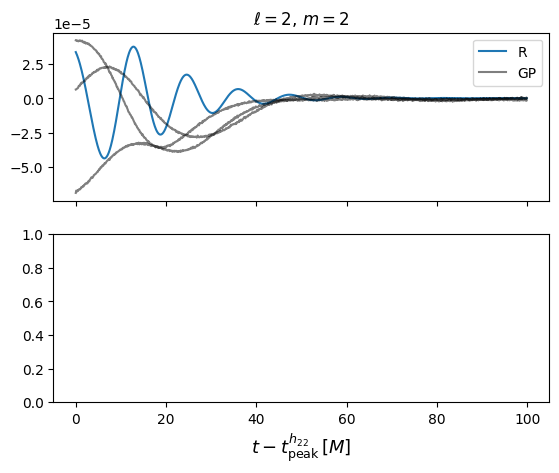

In [134]:
rng = np.random.default_rng()

fig, axs = plt.subplots(len(spherical_modes)+1, 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim_main.times[analysis_mask], np.real(R[ell,m])[analysis_mask], label='R')

    repeats = 3
    gp_samples = rng.multivariate_normal(np.zeros(n_times), kernel_dict[ell,m], size=repeats)
    for j, draw in enumerate(gp_samples):
        label = 'GP' if j == 0 else None
        axs[i].plot(analysis_times, draw, color='black', alpha=0.5, label=label)

    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$', fontsize=13)

axs[0].legend();

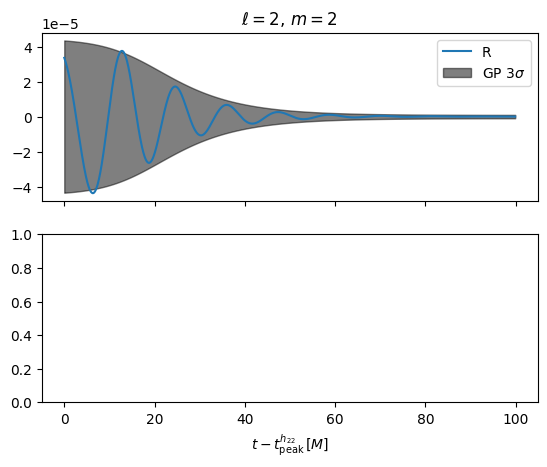

In [135]:
fig, axs = plt.subplots(len(spherical_modes)+1, 1, sharex=True)

for i, (ell,m) in enumerate(spherical_modes):

    axs[i].plot(sim_main.times[analysis_mask], np.real(R[ell,m])[analysis_mask], label='R')
    #axs[i].plot(ls_fit['model_times'], ls_fit['model'][(2,2,0,1)], label='R')

    # Plot the 1-sigma credible region of the GP
    axs[i].fill_between(
        analysis_times, 
        -np.sqrt(np.diag(kernel_dict[ell,m])), 
        np.sqrt(np.diag(kernel_dict[ell,m])),
        color='black', 
        alpha=0.5,
        label='GP 3$\sigma$'
        );

    axs[i].set_title(rf'$\ell = {ell},\, m = {m}$')

axs[-1].set_xlabel('$t-t_\mathrm{peak}^{h_{22}}\, [M]$')

axs[0].legend();

In [136]:
kernel_dict_inv = {(ell,m): np.linalg.inv(kernel_dict[ell,m]) for ell,m in spherical_modes}

# Convert kernel_dict_inv to a matrix
kernel_matrix_inv = np.zeros((len(spherical_modes), n_times, n_times), dtype=np.complex128)

for idx, (ell, m) in enumerate(spherical_modes):
    kernel_matrix_inv[idx, :, :] = kernel_dict_inv[(ell, m)]

In [137]:
test_kernel_inv = np.array([np.eye(n_times) for _ in spherical_modes]) /  1e-5**2

fisher_matrix_full = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, kernel_matrix_inv)  
b_vec_full = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, kernel_matrix_inv)

fisher_matrix_id = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, test_kernel_inv)
b_vec_id = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, test_kernel_inv)

fisher_matrix_1 = get_fisher_matrix(qnm_list, spherical_modes, sim_main.times, Mf_0, chif_mag_0, 1e-5)
b_vec_1 = get_b_vector(qnm_list, spherical_modes, t0, sim_main.times, sim_main.h, Mf_0, chif_mag_0, 1e-5)

Precomputation time:  0.001173257827758789
Fisher matrix computation time:  0.36020684242248535
Precomputation time:  0.00064849853515625
Fisher matrix computation time:  0.33451342582702637
Precomputation time:  0.0006649494171142578
Fisher matrix computation time:  0.0017502307891845703


In [138]:
mean_vector_full = np.linalg.solve(fisher_matrix_full, b_vec_full)
mean_vector_id = np.linalg.solve(fisher_matrix_id, b_vec_id)
mean_vector_1 = np.linalg.solve(fisher_matrix_1, b_vec_1)

covariance_matrix = np.linalg.inv(fisher_matrix_full)
covariance_matrix_id = np.linalg.inv(fisher_matrix_id)

In [139]:
print(mean_vector_full)
print(mean_vector_id)
print(mean_vector_1)

print(true_params)

[  0.96512364  -0.20436137  -3.15092794  -2.99933373   5.72052672
  11.98095059 -12.46799721 -30.58223466  24.99334088  49.77873809
 -30.07420659 -44.59606325  17.64912643  20.21022918  -3.87659509
  -3.92833265]
[  0.96343041  -0.20376214  -3.00253882  -2.9400435    4.45699608
  10.22783793  -9.25742132 -20.34633003  19.95416558  25.14712045
 -24.15107845 -16.23628766  13.88508074   4.35372109  -3.06357046
  -0.33389693]
[  0.9634397   -0.2037557   -3.00311357  -2.94033697   4.46596992
  10.23061682  -9.31641674 -20.35192307  20.13534142  25.11881291
 -24.41047352 -16.13556122  14.06274956   4.25033173  -3.11252871
  -0.29975581]
[0.9634304115416662, -0.20376214134289608, -3.0025388346811464, -2.940043480261583, 4.45699618766639, 10.227837648865886, -9.257421626232611, -20.34632836846052, 19.954165375569016, 25.14711576818095, -24.151076879957103, -16.236281419359873, 13.885079058612202, 4.353717123669431, -3.0635699319636505, -0.33389592817851815]


In [141]:
covariance_matrix_reg = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-10
covariance_matrix_id_reg = covariance_matrix_id + np.eye(covariance_matrix_id.shape[0]) * 1e-10

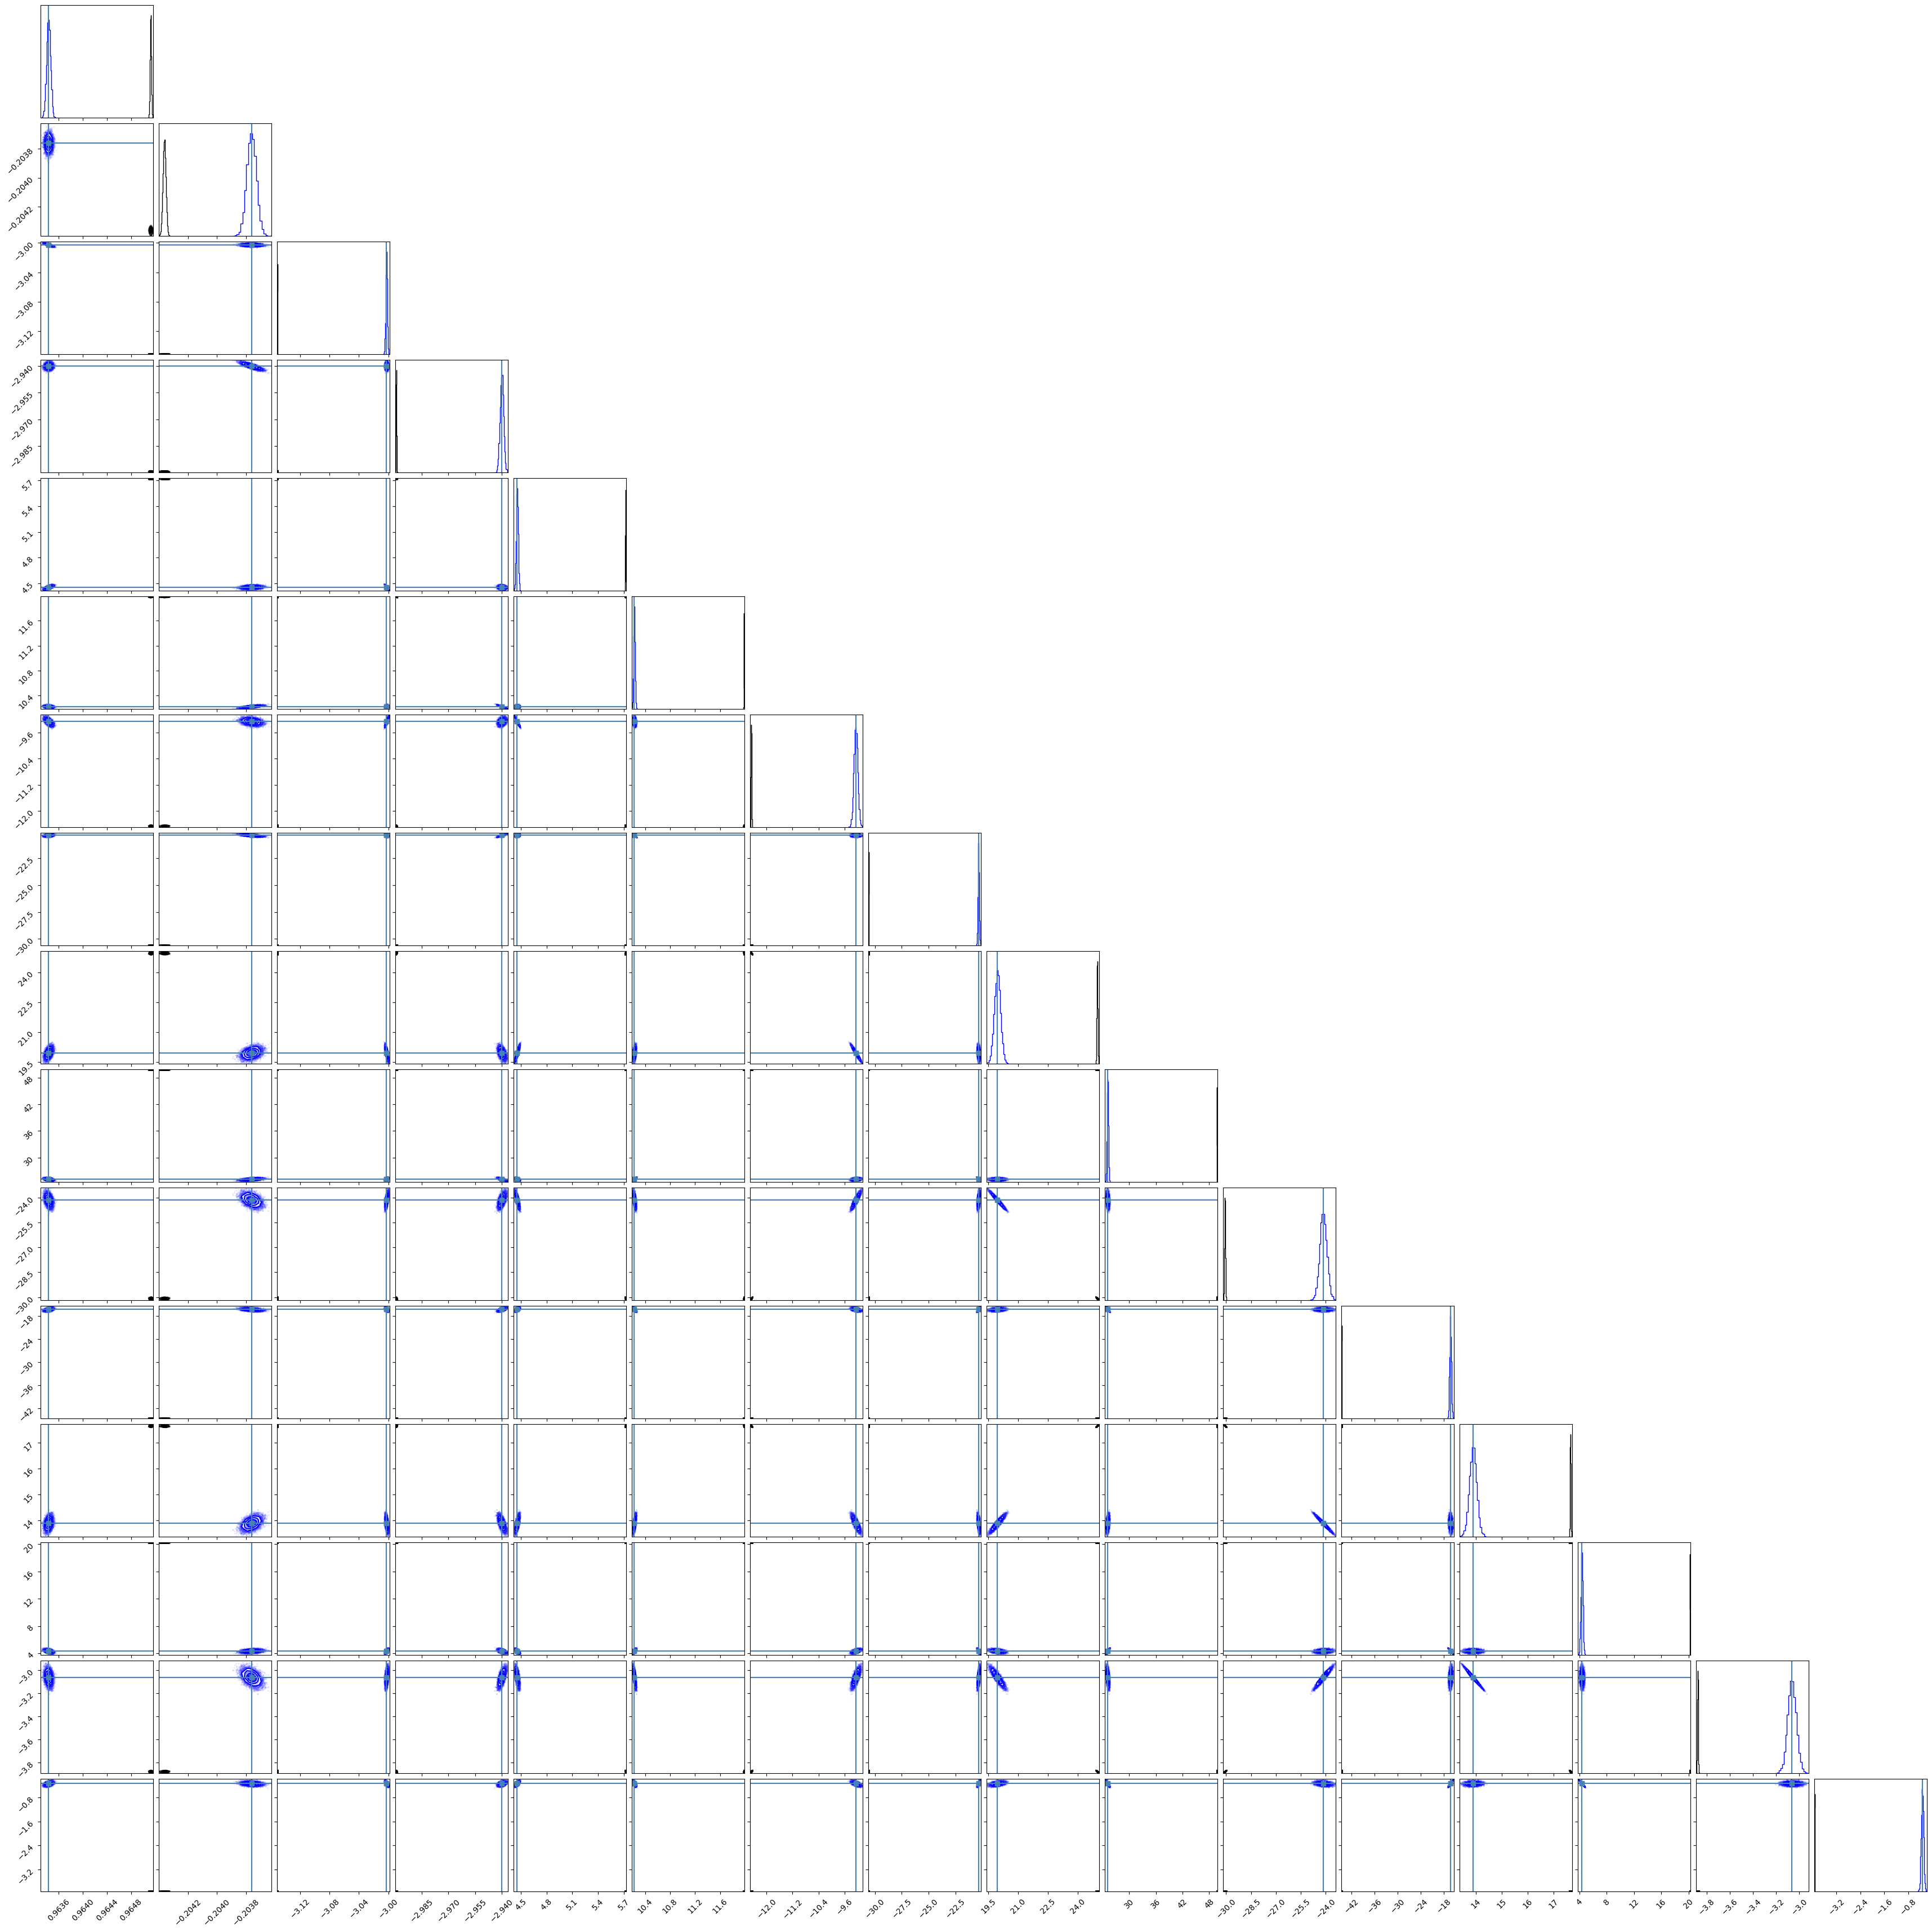

In [142]:
samples = scipy.stats.multivariate_normal(mean_vector_full, covariance_matrix_reg, allow_singular=True).rvs(size=10000)
samples_ = scipy.stats.multivariate_normal(mean_vector_id, covariance_matrix_id_reg, allow_singular=True).rvs(size=10000)

fig = corner.corner(
    samples,
    truths=true_params)

#corner.corner(
#   samples_,
#    truths=true_params,
#    fig=fig,
#    color='blue'
#)

plt.show()

In [143]:
def qnm_model(times, t0, amps, qnm_list, spherical_modes, mass, spin):

    model = { mode: np.zeros_like(times, dtype=complex) for mode in spherical_modes }

    for i, qnm in enumerate(qnm_list):  

        amp = amps[2*i] + 1j*amps[2*i+1]

        omega = qnmfits.qnm.omega(*qnm, spin, Mf=mass)

        for ell, m in spherical_modes:

            mu = qnmfits.qnm.mu(ell, m, qnm[0], qnm[1], qnm[2], qnm[3], spin)

            model[ell, m] += amp * mu * np.exp(-1j*omega*(times-t0))

    return model


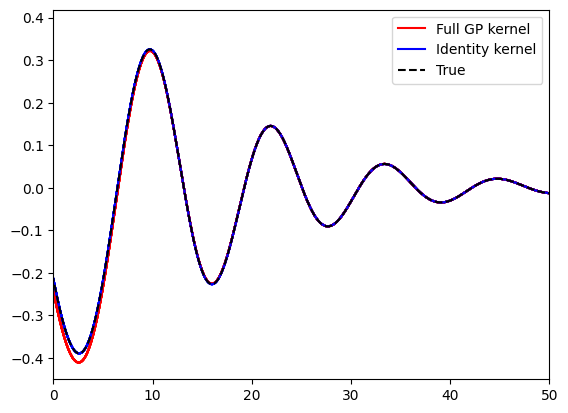

In [144]:
num_samples, num_dim = samples.shape

num_draws = 10

indices = np.random.choice(np.arange(num_samples), size=num_draws, replace=False)

ell, m = 2, 2
posterior_signals = np.zeros((num_draws, len(analysis_times)), dtype=complex)
posterior_signals_ = np.zeros((num_draws, len(analysis_times)), dtype=complex)

for i, idx in enumerate(indices):
    posterior_signals[i] = qnm_model(analysis_times, t0, samples[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]
    posterior_signals_[i] = qnm_model(analysis_times, t0, samples_[idx], qnm_list, spherical_modes, Mf_0, chif_mag_0)[(ell, m)]

    plt.plot(analysis_times, np.real(posterior_signals[i]), label='Full GP kernel' if i==0 else None, color='r')
    plt.plot(analysis_times, np.real(posterior_signals_[i]), label='Identity kernel' if i==0 else None, color='b')

plt.plot(sim_main.times, np.real(sim_main.h[ell,m]), label='True', color='black', ls='--')

plt.xlim(0, 50)
plt.legend()
plt.show()
